In [42]:
import numpy as np
import matplotlib.pyplot as plt 
class RecurrentNeuralNetwork:
    #input (word), expected output (next word), num of words (num of recurrences), array expected outputs, learning rate
    def __init__ (self, xs, ys, rl, eo, lr):
        #initial input (first word)
        self.x = np.zeros(xs)
        #input size 
        self.xs = xs
        #expected output (next word)
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #weight matrix for interpreting results from LSTM cell (num words x num words matrix)
        self.w = np.random.random((ys, ys))
        #matrix used in RMSprop
        self.G = np.zeros_like(self.w)
        #length of the recurrent network - number of recurrences i.e num of words
        self.rl = rl
        #learning rate 
        self.lr = lr
        #array for storing inputs
        self.ia = np.zeros((rl+1,xs))
        #array for storing cell states
        self.ca = np.zeros((rl+1,ys))
        #array for storing outputs
        self.oa = np.zeros((rl+1,ys))
        #array for storing hidden states
        self.ha = np.zeros((rl+1,ys))
        #forget gate 
        self.af = np.zeros((rl+1,ys))
        #input gate
        self.ai = np.zeros((rl+1,ys))
        #cell state
        self.ac = np.zeros((rl+1,ys))
        #output gate
        self.ao = np.zeros((rl+1,ys))
        #array of expected output values
        self.eo = np.vstack((np.zeros(eo.shape[0]), eo.T))
        #declare LSTM cell (input, output, amount of recurrence, learning rate)
        self.LSTM = LSTM(xs, ys, rl, lr)
    
    #activation function. simple nonlinearity, convert nums into probabilities between 0 and 1
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    #the derivative of the sigmoid function. used to compute gradients for backpropagation
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))    
    
    #lets apply a series of matrix operations to our input (curr word) to compute a predicted output (next word)
    def forwardProp(self):
        for i in range(1, self.rl+1):
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            cs, hs, f, inp, c, o = self.LSTM.forwardProp()
            #store computed cell state
            self.ca[i] = cs
            self.ha[i] = hs
            self.af[i] = f
            self.ai[i] = inp
            self.ac[i] = c
            self.ao[i] = o
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            self.x = self.eo[i-1]
        return self.oa
   
    
    def backProp(self):
        #update our weight matrices (Both in our Recurrent network, as well as the weight matrices inside LSTM cell)
        #init an empty error value 
        totalError = 0
        #initialize matrices for gradient updates
        #First, these are RNN level gradients
        #cell state
        dfcs = np.zeros(self.ys)
        #hidden state,
        dfhs = np.zeros(self.ys)
        #weight matrix
        tu = np.zeros((self.ys,self.ys))
        #Next, these are LSTM level gradients
        #forget gate
        tfu = np.zeros((self.ys, self.xs+self.ys))
        #input gate
        tiu = np.zeros((self.ys, self.xs+self.ys))
        #cell unit
        tcu = np.zeros((self.ys, self.xs+self.ys))
        #output gate
        tou = np.zeros((self.ys, self.xs+self.ys))
        #loop backwards through recurrences
        for i in range(self.rl, -1, -1):
            #error = calculatedOutput - expectedOutput
            error = self.oa[i] - self.eo[i]
            #calculate update for weight matrix
            #(error * derivative of the output) * hidden state
            tu += np.dot(np.atleast_2d(error * self.dsigmoid(self.oa[i])), np.atleast_2d(self.ha[i]).T)
            #Time to propagate error back to exit of LSTM cell
            #1. error * RNN weight matrix
            error = np.dot(error, self.w)
            #2. set input values of LSTM cell for recurrence i (horizontal stack of arrays, hidden + input)
            self.LSTM.x = np.hstack((self.ha[i-1], self.ia[i]))
            #3. set cell state of LSTM cell for recurrence i (pre-updates)
            self.LSTM.cs = self.ca[i]
            #Finally, call the LSTM cell's backprop, retreive gradient updates
            #gradient updates for forget, input, cell unit, and output gates + cell states & hiddens states
            fu, iu, cu, ou, dfcs, dfhs = self.LSTM.backProp(error, self.ca[i-1], self.af[i], self.ai[i], self.ac[i], self.ao[i], dfcs, dfhs)
            #calculate total error (not necesarry, used to measure training progress)
            totalError += np.sum(error)
            totalError+=(np.sum(error/self.w)/error.size)%5
            #accumulate all gradient updates
            #forget gate
            tfu += fu
            #input gate
            tiu += iu
            #cell state
            tcu += cu
            #output gate
            tou += ou
        #update LSTM matrices with average of accumulated gradient updates    
        self.LSTM.update(tfu/self.rl, tiu/self.rl, tcu/self.rl, tou/self.rl) 
        #update weight matrix with average of accumulated gradient updates  
        self.update(tu/self.rl)
        #return total error of this iteration
        return totalError/1000
    
    def update(self, u):
        #vanilla implementation of RMSprop
        self.G = 0.9 * self.G + 0.1 * u**2  
        self.w -= self.lr/np.sqrt(self.G + 1e-8) * u
        return
    
    #this is where we generate some sample text after having fully trained our model
    #i.e error is below some threshold
    def sample(self):
         #loop through recurrences - start at 1 so the 0th entry of all arrays will be an array of 0's
        for i in range(1, self.rl+1):
            #set input for LSTM cell, combination of input (previous output) and previous hidden state
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            #run forward prop on the LSTM cell, retrieve cell state and hidden state
            cs, hs, f, inp, c, o = self.LSTM.forwardProp()
            #store input as vector
            maxI = np.argmax(self.x)
            self.x = np.zeros_like(self.x)
            self.x[maxI] = 1
            self.ia[i] = self.x #Use np.argmax?
            #store cell states
            self.ca[i] = cs
            #store hidden state
            self.ha[i] = hs
            #forget gate
            self.af[i] = f
            #input gate
            self.ai[i] = inp
            #cell state
            self.ac[i] = c
            #output gate
            self.ao[i] = o
            #calculate output by multiplying hidden state with weight matrix
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            #compute new input
            maxI = np.argmax(self.oa[i])
            newX = np.zeros_like(self.x)
            newX[maxI] = 1
            self.x = newX
        #return all outputs    
        return self.oa

In [43]:
class LSTM:
    # LSTM cell (input, output, amount of recurrence, learning rate)
    def __init__ (self, xs, ys, rl, lr):
        #input is word length x word length
        self.x = np.zeros(xs+ys)
        #input size is word length + word length
        self.xs = xs + ys
        #output 
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #cell state intialized as size of prediction
        self.cs = np.zeros(ys)
        #how often to perform recurrence
        self.rl = rl
        #balance the rate of training (learning rate)
        self.lr = lr
        #init weight matrices for our gates
        #forget gate
        self.f = np.random.random((ys, xs+ys))
        #input gate
        self.i = np.random.random((ys, xs+ys))
        #cell state
        self.c = np.random.random((ys, xs+ys))
        #output gate
        self.o = np.random.random((ys, xs+ys))
        #forget gate gradient
        self.Gf = np.zeros_like(self.f)
        #input gate gradient
        self.Gi = np.zeros_like(self.i)
        #cell state gradient
        self.Gc = np.zeros_like(self.c)
        #output gate gradient
        self.Go = np.zeros_like(self.o)
    
    #activation function to activate our forward prop, just like in any type of neural network
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    #derivative of sigmoid to help computes gradients
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    #tanh! another activation function, often used in LSTM cells
    #Having stronger gradients: since data is centered around 0, 
    #the derivatives are higher. To see this, calculate the derivative 
    #of the tanh function and notice that input values are in the range [0,1].
    def tangent(self, x):
        return np.tanh(x)
    
    #derivative for computing gradients
    def dtangent(self, x):
        return 1 - np.tanh(x)**2
    
    #lets compute a series of matrix multiplications to convert our input into our output
    def forwardProp(self):
        f = self.sigmoid(np.dot(self.f, self.x))
        self.cs *= f
        i = self.sigmoid(np.dot(self.i, self.x))
        c = self.tangent(np.dot(self.c, self.x))
        self.cs += i * c
        o = self.sigmoid(np.dot(self.o, self.x))
        self.y = o * self.tangent(self.cs)
        return self.cs, self.y, f, i, c, o
    
   
    def backProp(self, e, pcs, f, i, c, o, dfcs, dfhs):
        #error = error + hidden state derivative. clip the value between -6 and 6.
        e = np.clip(e + dfhs, -6, 6)
        #multiply error by activated cell state to compute output derivative
        do = self.tangent(self.cs) * e
        #output update = (output deriv * activated output) * input
        ou = np.dot(np.atleast_2d(do * self.dtangent(o)).T, np.atleast_2d(self.x))
        #derivative of cell state = error * output * deriv of cell state + deriv cell
        dcs = np.clip(e * o * self.dtangent(self.cs) + dfcs, -6, 6)
        #deriv of cell = deriv cell state * input
        dc = dcs * i
        #cell update = deriv cell * activated cell * input
        cu = np.dot(np.atleast_2d(dc * self.dtangent(c)).T, np.atleast_2d(self.x))
        #deriv of input = deriv cell state * cell
        di = dcs * c
        #input update = (deriv input * activated input) * input
        iu = np.dot(np.atleast_2d(di * self.dsigmoid(i)).T, np.atleast_2d(self.x))
        #deriv forget = deriv cell state * all cell states
        df = dcs * pcs
        #forget update = (deriv forget * deriv forget) * input
        fu = np.dot(np.atleast_2d(df * self.dsigmoid(f)).T, np.atleast_2d(self.x))
        #deriv cell state = deriv cell state * forget
        dpcs = dcs * f
        #deriv hidden state = (deriv cell * cell) * output + deriv output * output * output deriv input * input * output + deriv forget
        #* forget * output
        dphs = np.dot(dc, self.c)[:self.ys] + np.dot(do, self.o)[:self.ys] + np.dot(di, self.i)[:self.ys] + np.dot(df, self.f)[:self.ys] 
        #return update gradinets for forget, input, cell, output, cell state, hidden state
        return fu, iu, cu, ou, dpcs, dphs
            
    def update(self, fu, iu, cu, ou):
        #update forget, input, cell, and output gradients
        self.Gf = 0.9 * self.Gf + 0.1 * fu**2 
        self.Gi = 0.9 * self.Gi + 0.1 * iu**2   
        self.Gc = 0.9 * self.Gc + 0.1 * cu**2   
        self.Go = 0.9 * self.Go + 0.1 * ou**2   
        
        #update our gates using our gradients
        self.f -= self.lr/np.sqrt(self.Gf + 1e-8) * fu
        self.i -= self.lr/np.sqrt(self.Gi + 1e-8) * iu
        self.c -= self.lr/np.sqrt(self.Gc + 1e-8) * cu
        self.o -= self.lr/np.sqrt(self.Go + 1e-8) * ou
        return

In [44]:
def LoadText():
    #open text and return input and output data (series of words)
    with open("data.txt", "r") as text_file:
        data = text_file.read()
    text = list(data)
    outputSize = len(text)
    data = list(set(text))
    uniqueWords, dataSize = len(data), len(data) 
    returnData = np.zeros((uniqueWords, dataSize))
    for i in range(0, dataSize):
        returnData[i][i] = 1
    returnData = np.append(returnData, np.atleast_2d(data), axis=0)
    output = np.zeros((uniqueWords, outputSize))
    for i in range(0, outputSize):
        index = np.where(np.asarray(data) == text[i])
        output[:,i] = returnData[0:-1,index[0]].astype(float).ravel()  
    return returnData, uniqueWords, output, outputSize, data

#write the predicted output (series of words) to disk
def ExportText(output, data):
    finalOutput = np.zeros_like(output)
    prob = np.zeros_like(output[0])
    outputText = ""
    print(len(data))
    print(output.shape[0])
    for i in range(0, output.shape[0]):
        v=0.0
        for j in range(0, output.shape[1]):
            v+=output[i][j]
        for j in range(0, output.shape[1]):
            if v!=0:
                prob[j] = output[i][j] / v #np.sum(output[i])
            else:
                prob[j]=1/output.shape[1]
        outputText += np.random.choice(data,p=prob)    
    with open("output.txt", "w") as text_file:
        text_file.write(outputText)
    return

Beginning
Done Reading
Error on iteration  1 :  495.8511574333196
Error on iteration  2 :  494.05157665763414
Error on iteration  3 :  491.95618911763603
Error on iteration  4 :  489.8877775461037
Error on iteration  5 :  487.664288373155
Error on iteration  6 :  485.9837876185557
Error on iteration  7 :  485.28627383092277
Error on iteration  8 :  484.36596687726285
Error on iteration  9 :  482.46200916254315
Error on iteration  10 :  481.1924892977981
Error on iteration  11 :  480.0665974285919
Error on iteration  12 :  479.2254948349773
Error on iteration  13 :  477.7687248814217
Error on iteration  14 :  477.2143940028341
Error on iteration  15 :  476.32199028043397
Error on iteration  16 :  474.7360259316941
Error on iteration  17 :  473.6691295019412
Error on iteration  18 :  472.38341109797415
Error on iteration  19 :  471.8433210852419
Error on iteration  20 :  470.4292287234066
Error on iteration  21 :  469.7018195719866
Error on iteration  22 :  468.2748615435241
Error on ite

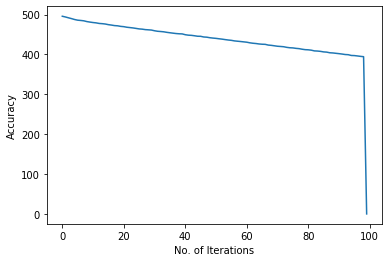

In [45]:
#Begin program    
print("Beginning")
iterations = 100
learningRate = 0.001
#load input output data (words)
returnData, numCategories, expectedOutput, outputSize, data = LoadText()
print("Done Reading")
#init our RNN using our hyperparams and dataset
RNN = RecurrentNeuralNetwork(numCategories, numCategories, outputSize, expectedOutput, learningRate)
t = np.zeros([iterations])
#training time!
for i in range(1, iterations):
    #compute predicted next word
    RNN.forwardProp()
    #update all our weights using our error
    error = RNN.backProp()
    #once our error/loss is small enough
    print("Error on iteration ", i, ": ", error)
    t[i-1] = error
    if error > -100 and error < 100 or i % 100 == 0:
        #we can finally define a seed word
        seed = np.zeros_like(RNN.x)
        maxI = np.argmax(np.random.random(RNN.x.shape))
        seed[maxI] = 1
        RNN.x = seed  
        #and predict some new text!
        output = RNN.sample()
        #print(output)   
        #write it all to disk
        ExportText(output, data)
        print("Done Writing")
print("Complete")
s = np.arange(0, iterations, 1) 
plt.plot(s, t) 
plt.ylabel('Accuracy')
plt.xlabel('No. of Iterations')
plt.show() 